# Hyperparameter Tuning
Hyperparameters tuning is an important step in training machine learning models. With hyperparameter tuning for an objective function on a cross-validation set one can prevent overfitting or underfitting the model on training data. Looking for an optimal set of hyperparameters through the space of feasible values is a hard problem. Sagemaker provides the utility of hyperparameter tuning through Bayesian search.

In notebook follows the below steps:

* [Hyperparameter Configuration](#Hyperparameter-Configuration)
* [Job Configuration](#Job-Configuration)
* [Launching Tuning Job](#Launching-Tuning-Job)
* [Plotting results of Hyperparameter tuning](#Plotting-results-of-Hyperparameter-tuning)
* [Comparison of Results](#Comparison-of-Results)

In [1]:
# Preparing all imports
% matplotlib inline
import os
import json
import boto3
import sagemaker
import pandas as pd
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
import bokeh
import bokeh.io

bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

import warnings

warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name

# Hyperparameter Configuration

In [3]:
%%time

# Fixed Hyperparameters
hyperparameters = {
    "time_freq": 'D',
    "prediction_length": '14',
    "epochs": "500",
    "likelihood": "deterministic-L1",  # point forecast
    "early_stopping_patience": "40"

}

# Variable Hyperparameters
hyperparameter_ranges = {'learning_rate': ContinuousParameter(1e-5, 1e-1),
                         "context_length": IntegerParameter(7, 14),
                         "mini_batch_size": IntegerParameter(32, 256),
                         "num_cells": IntegerParameter(30, 200),
                         "num_layers": IntegerParameter(1, 8),
                         "dropout_rate": ContinuousParameter(0.0, 0.2),
                         "embedding_dimension": IntegerParameter(1, 20)
                         }

CPU times: user 17 µs, sys: 3 µs, total: 20 µs
Wall time: 22.9 µs


Get the information about location of s3 output path, training and testing data dumped by the main notebook.

In [4]:
location_dict = json.loads((open("location.json").read()))


# Job Configuration 

In [5]:
# Pulling docker image containing the DeepAR model
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.2xlarge',
    base_job_name='deepar-timeseries',
    output_path=location_dict['s3_output_path'],
    hyperparameters=hyperparameters,
    tags=[{"Key": "project", "Value": "SageMaker_Demo"}]
)

# Objective function for tuning
objective_metric_name = 'test:RMSE'
objective_type = 'Minimize'

tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=50,
                            max_parallel_jobs=5,
                            objective_type=objective_type,
                            tags=[{"Key": "project", "Value": "Sagemaker_Demo"}])

Launch the hyperparameter tuning job. It will run 'max_jobs' training jobs and carry out Bayesian Optimization of the objective metric. In Bayesian Optimization, the tuner uses information from the jobs it has ran so far to get a posterior distribution in the hyperparameter space. Based on this it samples the next set of hyperparameters to train with. This will accelerate the search for best hyperparameters as compared to grid search.

# Launching Tuning Job

In [6]:
tuner.fit(
    inputs={
        "train": location_dict['train_data_location'],
        "test": location_dict['test_data_location']
    },
    wait=True
)

INFO:sagemaker:Creating hyperparameter tuning job with name: forecasting-deepar-181108-1250


You can track the progress of the hyperparameter tuning job on the console [here](https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/hyper-tuning-jobs)

When the above tuning job is over get its results by running the cell below.

In [55]:
sage_client = boto3.Session().client('sagemaker')
tuning_job_name = tuner._current_job_name

#='forecasting-deepar-181029-1533'

tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
tuning_ranges=tuner.tuning_ranges
full_df = tuner.dataframe()

You can also run the following cell to view precomputed Hyperparameter Tuning results.

In [62]:
tuning_ranges = json.loads((open("tuning_ranges.json").read()))
full_df       = pd.read_csv('tuner_results.csv')
full_df['TrainingStartTime']=[pd.Timestamp(item) for item in full_df['TrainingStartTime']] 

# Plotting results of Hyperparameter tuning

In [63]:
is_minimize = True


if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest": min(df['FinalObjectiveValue']), "highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")


class HoverHelper():
    def __init__(self, tuning_ranges):
        self.tuning_ranges = tuning_ranges

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuning_ranges.keys():
            tooltips.append((k, "@{%s}" % k))

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

    

hover = HoverHelper(tuning_ranges)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Number of training jobs with valid objective: 50
{'lowest': 82.7457046508789, 'highest': 762.1106567382812}


In [26]:
ranges = tuning_ranges
figures = []
objective_metric_name = 'test:RMSE'

for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0


        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500,
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_metric_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

Hyperparameter tuning is supervised learning problem in high dimensional parameter space. It is difficult to identify the impact of interaction of parameters on the objective function through 2D scatter plots. Yet from the above plots, it is apparent that learning rate is the most important hyperparameter for our use case and its optimal value is of the order of 1e-3.      

# Comparison of Results

Following is the comparison of 28 days of point forecast obtained for learning rate of 0.1 vs 0.001, all the other hyperparameters remaining default.

In [11]:
df = pd.read_csv('learning_rate_comparison.csv')
df.set_index('date', inplace=True)

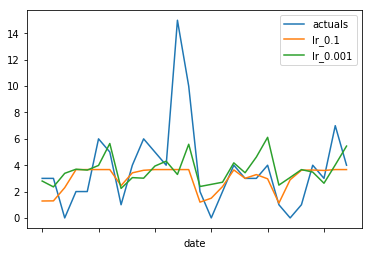

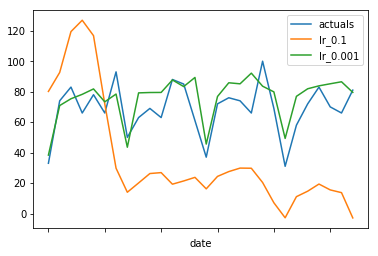

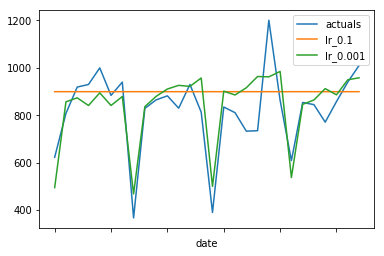

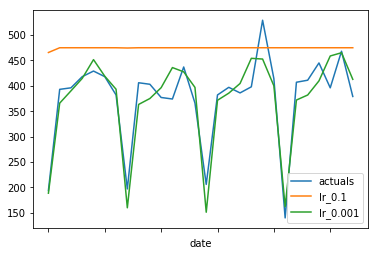

In [12]:
for item in df.store.unique():
    df[df['store'] == item].plot(y=['actuals', 'lr_0.1', 'lr_0.001'], legend=True)